In [1]:
# Make sure we can run the rest of the notebook.
import sys
if sys.version_info < (3, 6):
    print("WARNING: Python >= 3.6 is needed to run large parts of this notebook")

In [2]:
_SAVE_PLOTS_ = False

In [3]:
# Install additional depencencies.
!pip install keras-tqdm --user

    100% |████████████████████████████████| 51kB 2.4MB/s ta 0:00:01
You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [5]:
def clean_string(s):
    return s.replace("\'", "").replace(" ", "-").replace(",", "-").lower()

def save_figure(func):
    """Decorator for saving figures."""

    def wrapper(*args, **kwargs):
        fig = func(*args, **kwargs)
        if fig is None:
            return fig
        if _SAVE_PLOTS_:
            s = clean_string(fig._suptitle.get_text())
            fig.savefig(f"{_PATH_TO_FIGURES_}/{s}.png")
        return fig
    return wrapper

In [6]:
def plot_some_samples(x, y=[], yhat=[], select_from=[],
                      ncols=6, nrows=4, xdim=28, ydim=28,
                      label_mapping=range(10), legacy_labelling=False):
    """Plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty,
    select_from becomes range(N)).
    
    Keyword arguments:
    y                -- corresponding labels to plot in green below each image.
    yhat             -- corresponding predicted labels to plot in red below each image.
    select_from      -- list of indices from which to select the images.
    ncols, nrows     -- number of columns and rows to plot.
    xdim, ydim       -- number of pixels of the images in x- and y-direction.
    label_mapping    -- map labels to digits.
    legacy_labelling -- if True, offset labels by 1. This was the behavior of the original version given to us.
    """

    offset = 1 if legacy_labelling else 0
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+offset)%10, color='green',
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+offset)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

@save_figure
def plot_history(history, title, save_fig=True):
    best_loss = np.argmin(history.history['val_loss'])
    best_accuracy = np.argmax(history.history['val_acc'])
    
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax1.axvline(x=best_loss, color='g')
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    ax2.axvline(x=best_accuracy, color='g')
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [7]:
# super important as I am running multiple things on the same machine and I don't want to block the whole GPU
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [8]:
def plot_model(model):
    try:
        return Image(model_to_dot(model).create(prog='dot', format='png'))
    except ImportError as e:
        print(e)
        return None

def fix_layout(width:int=95):
    """Change screen layout width."""
    from IPython.core.display import display, HTML
    display(HTML('<style>.container { width:' + str(width) + '% !important; }</style>'))

fix_layout()

In [9]:
from keras.datasets import fashion_mnist

(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = fashion_mnist.load_data()

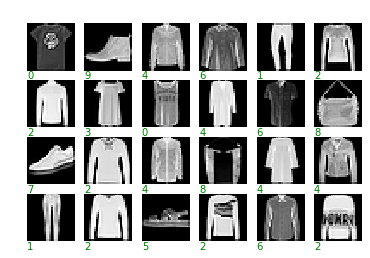

In [10]:
plot_some_samples(X_train_raw, y_train_raw);

In [11]:
y_train = keras.utils.to_categorical(y_train_raw)
y_test = keras.utils.to_categorical(y_test_raw)

In [12]:
def transform_images(X, max_x_value=255):
    """Flatten and rescale input."""
    # Divide by a fixed value to be sure that we are making the same
    # transformation on training and test data.
    return X.reshape(X.shape[0], -1) / max_x_value

X_train = transform_images(X_train_raw)
X_test = transform_images(X_test_raw)

In [20]:
from keras.callbacks import EarlyStopping

class Model:
    """Simple dense model"""

    def __init__(self, *, input_shape, dense_layer_defs, n_classes, dropout_pos=None, activation_hidden='relu', activation_output='softmax',
                 loss='categorical_crossentropy', optimizer='sgd', metrics=None, early_stopping_patience=None, use_bias=True,
                 kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None):
        if metrics is None:
            metrics = ['accuracy']

        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics
        self.dropout_pos = dropout_pos

        if early_stopping_patience is not None:
            self.callbacks = [EarlyStopping(monitor='val_loss', patience=early_stopping_patience)]
        else:
            self.callbacks = None

        hidden_layer_kwargs = {
            'activation': activation_hidden,
            'use_bias': use_bias,
            'kernel_regularizer': kernel_regularizer,
            'bias_regularizer': bias_regularizer,
            'activity_regularizer': activity_regularizer,
        }

        self._model = Sequential()
        for idx, output_shape in enumerate(dense_layer_defs):
            self._model.add(Dense(output_shape, name=f'hidden_layer_{idx}', **hidden_layer_kwargs))
            if idx == dropout_pos:
                self._model.add(Dropout(rate=0.2))
            
        self._model.add(Dense(n_classes, activation=activation_output, name='output_layer'))
        
        self.summary = self._model.summary
        self.predict_classes = self._model.predict_classes

        # This attribute is set in the method fit().
        self.history = None

    def fit(self, X_train, y_train, x_val, y_val, batch_size, epochs, verbosity=0):
        """Train and return the model."""
        self._model.compile(loss=self.loss,
                            optimizer=self.optimizer,
                            metrics=self.metrics)
        self.history = self._model.fit(X_train, y_train,
                                       batch_size=batch_size,
                                       epochs=epochs,
                                       verbose=verbosity,
                                       validation_data=(x_val, y_val),
                                       callbacks=self.callbacks)
        return self

In [14]:
from collections import namedtuple

ModelConfigs = namedtuple('ModelConfigs', 'model, fit')

N_EPOCHS = 100

model_config = {
    "input_shape": X_train.shape[1:],
    "n_classes": y_train.shape[1],
    "dense_layer_defs": [32, 32, 32],
    "dropout_pos": None,
}

fit_config = {
    "X_train": X_train,
    "y_train": y_train,
    "x_val": X_test,
    "y_val": y_test,
    "batch_size": 100,
    "epochs": 100,
}

In [15]:
def best_evaluation(history):
    """Return the best-ever loss and accuracy.

    Not necessarily from the same epoch."""

    best_loss = min(history.history['val_loss'])
    best_accuracy = max(history.history['val_acc'])
    return best_loss, best_accuracy

def train_and_eval_model(model_config, fit_config, title="DropoutInvestigation"):
    """Train a model, evaluate it, and plot its performance."""

    model = Model(**model_config).fit(**fit_config)

    loss, accuracy = best_evaluation(model.history)
    print(f"{title}. Best-ever validation loss: {loss:.3f}, best-ever validation accuracy: {accuracy:.3f}")
    print("The green line marks the epoch where the best metric was achieved.")

    #plot_history(model.history, title)

    return model

In [22]:
def plot_misclassified(model, data, labels):
    """Sample and plot misclassified images."""
    predicted = model.predict_classes(data)
    misclassified = np.flatnonzero(predicted != labels)
    plot_some_samples(data, labels, predicted, misclassified)

FNN using only dense layers of outputs: [32, 32, 32], and a dropout layer at pos 0. Best-ever validation loss: 0.361, best-ever validation accuracy: 0.872
The green line marks the epoch where the best metric was achieved.
FNN using only dense layers of outputs: [32, 32, 32], and a dropout layer at pos 1. Best-ever validation loss: 0.354, best-ever validation accuracy: 0.876
The green line marks the epoch where the best metric was achieved.
FNN using only dense layers of outputs: [32, 32, 32], and a dropout layer at pos 2. Best-ever validation loss: 0.369, best-ever validation accuracy: 0.871
The green line marks the epoch where the best metric was achieved.


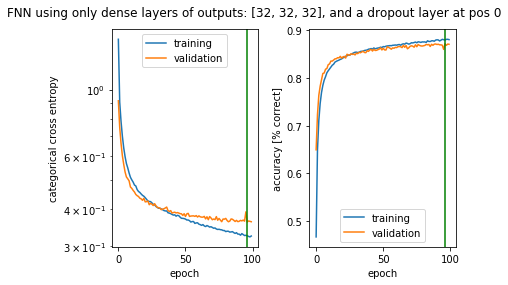

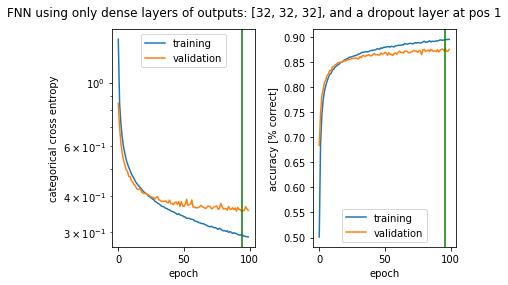

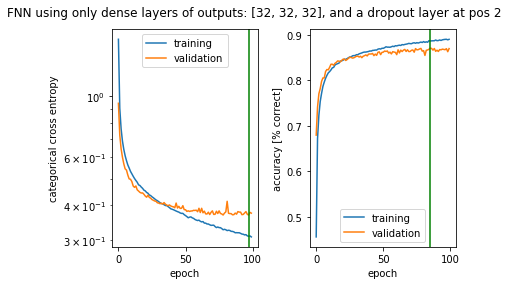

In [23]:
dense_mdls = [train_and_eval_model({**model_config, 'dropout_pos': pos},
                           fit_config,
                           title=f"FNN using only dense layers of outputs: {model_config['dense_layer_defs']}, and a dropout layer at pos {pos}")
              for pos in range(len(model_config['dense_layer_defs']))]

In [39]:
def plot_comparison(models):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
    colors = sns.color_palette(n_colors=len(models))

    for i, mdl in enumerate(models):
        ax[0].plot(mdl.history.history['loss'], label=f'training dropout pos {mdl.dropout_pos}', c=colors[i])
        ax[0].plot(mdl.history.history['val_loss'], label=f'validation pos {mdl.dropout_pos}', linestyle='dashed', c=colors[i])
        ax[1].plot(mdl.history.history['acc'], label=f'training pos {mdl.dropout_pos}', c=colors[i])
        ax[1].plot(mdl.history.history['val_acc'], label=f'validation pos {mdl.dropout_pos}', linestyle='dashed', c=colors[i])
        
    ax[0].set_xlabel('epochs')
    ax[1].set_xlabel('epochs')
    
    ax[0].set_ylabel('loss')
    ax[1].set_ylabel('acc')
    
    plt.legend()

    fig.suptitle("Comparing different dropout layer positions")
    return fig

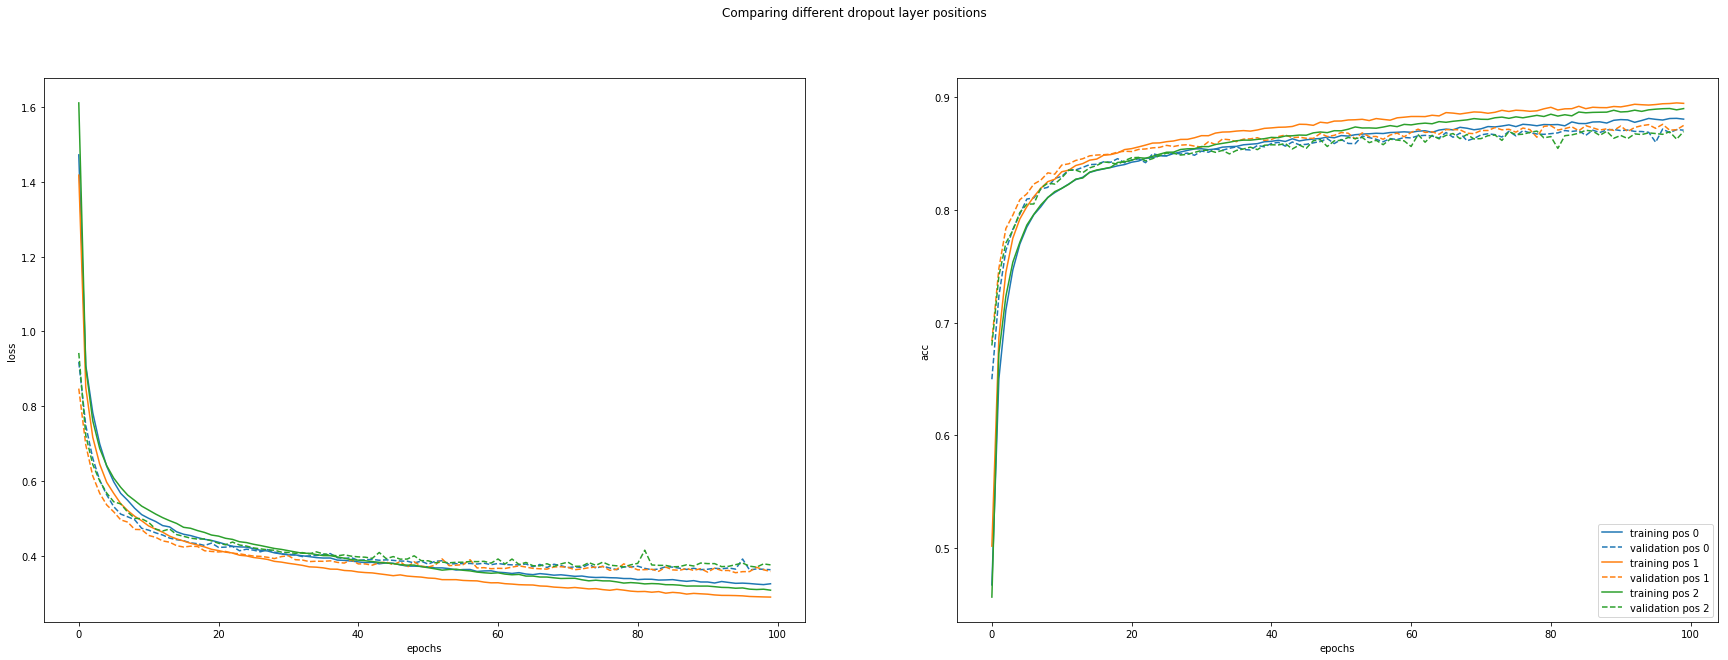

In [40]:
plot_comparison(dense_mdls);

In [43]:
dense_mdls[-1].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_0 (Dense)       (None, 32)                25120     
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 32)                1056      
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 32)                1056      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                330       
Total params: 27,562
Trainable params: 27,562
Non-trainable params: 0
_________________________________________________________________


In [45]:
np.argmin([best_evaluation(m.history)[0] for m in dense_mdls])

1

# Graveyard

In [18]:
stop

NameError: name 'stop' is not defined

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

In [ ]:
N_EPOCHS = 50
HIDDEN_LAYERS = [128]
N_LEARNING_RATES = 5

def get_1_hidden_layer_configs(lr):
    """Return config data for a model with one hidden layer and a given learning rate for SGD."""
    mnist_cfgs = get_configs(*mnist_data, dense_layer_defs=HIDDEN_LAYERS, epochs=N_EPOCHS)
    mnist_cfgs.model['activation_hidden'] = 'relu'
    mnist_cfgs.model['optimizer'] = SGD(lr=lr)
    return mnist_cfgs

def hist_for_lr(lr):
    """Train a model with the given learning rate and return the training history."""
    mnist_cfgs = get_1_hidden_layer_configs(lr)
    mdl = Model(**mnist_cfgs.model).fit(**mnist_cfgs.fit)
    return mdl.history, mdl

In [ ]:
@save_figure
def comparison_plot(history_sgd, history_adam, label1, label2, title, save_fig=True):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

In [ ]:
@save_figure
def plot_learning_rate_comparison(sgd_hists, adam_hist, save_fig=True):
    try:
        import seaborn as sns
    except ModuleNotFoundError as e:
        print(e)
        return None

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
    colors = sns.color_palette(n_colors=len(sgd_hists) + 1)

    for i, (lr, (sgd_hist, sgd_model)) in enumerate(sgd_hists):
        ax[0].plot(sgd_hist.history['loss'], label=f'training sgd {lr:.3f}', c=colors[i])
        ax[0].plot(sgd_hist.history['val_loss'], label=f'validation sgd {lr:.3f}', linestyle='dashed', c=colors[i])
        ax[1].plot(sgd_hist.history['acc'], label=f'training sgd {lr:.3f}', c=colors[i])
        ax[1].plot(sgd_hist.history['val_acc'], label=f'validation sgd {lr:.3f}', linestyle='dashed', c=colors[i])

    for i, (h, label) in enumerate(zip(['loss', 'acc'], ['categorical cross entropy', 'accuracy [% correct]'])):
        ax[i].plot(adam_hist.history[h], label='training adam', c=colors[-1])
        ax[i].plot(adam_hist.history[f'val_{h}'], label='validation adam', linestyle='dashed', c=colors[-1])
        ax[i].legend()
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(label)

    fig.suptitle("Comparing different SGD learning rates' with Adam's performace")
    return fig

In [ ]:
# If we called .fit() on the same model multiple times, we would be training the model incrementally.
# That is not what we want! So instead, we make a new model for each learning rate.
sgd_hists = [(lr, hist_for_lr(lr)) for lr in np.geomspace(0.01, 0.1, N_LEARNING_RATES)]

adam_cfgs = get_configs(*mnist_data, dense_layer_defs=HIDDEN_LAYERS, epochs=N_EPOCHS)
adam_cfgs.model['activation_hidden'] = 'relu'
adam_cfgs.model['optimizer'] = 'adam'
adam_mdl = Model(**adam_cfgs.model).fit(**adam_cfgs.fit)
adam_hist = adam_mdl.history

In [ ]:
plot_learning_rate_comparison(sgd_hists, adam_hist);

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) With a very large learning rate (0.1), the accuracy on the training set reaches close to 100% within 50 epochs, while the accuracy on the validation set stagnates around 98%.

B) With a very small learning rate (0.01), the accuracy on the training and validation set are each around 95-96% after 50 epochs, and both still seem to be rising.

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: The Adam optimizer starts to overfit around epoch 12, when the categorical cross entropy on the validation set starts to rise as the model begins to fit the noise of the data (consider also the below answer).

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: Whereas accuracy is a discrete measure with a hard cut-off point, cross-entropy (our loss metric) measures "how wrong" the model is. This can be seen for the Adam-optimized model: the cross-entropy shows an increasing difference in loss between training and validation set, but the accuracy stagnates. The predicted scores are getting less aligned with their labels, indicating overfitting.

In [ ]:
fashion_cfgs = get_configs(*fashion_data, dense_layer_defs=HIDDEN_LAYERS, epochs=200)
fashion_cfgs.model['activation_hidden'] = 'relu'
fashion_cfgs.model['optimizer'] = 'adam'

train_and_eval_model(fashion_cfgs, title="One hidden layer, using Adam, Fashion-MNIST");

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

In [ ]:
N_MODELS = 8
N_EPOCHS = 240    # In tests, we saw that overfitting starts before 240 epochs. 

@save_figure
def plot_results_vs_layer_size(best_results_by_layer_size, title_prefix, save_fig=True):
    """Plot loss and accuracy vs. the number of hidden neurons."""

    sizes, losses, accs, _ = zip(*best_results_by_layer_size)
    title = f"{title_prefix}: Validation loss and accuracy by hidden layer size"

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)

    ax1.scatter(sizes, losses, label='loss')
    ax1.set_xlabel('hidden layer size')
    ax1.set_ylabel('validation loss')
    ax1.set_xscale('log')
    ax1.set_yscale('log')

    ax2.scatter(sizes, accs, label='accuracy')
    ax2.set_xlabel('hidden layer size')
    ax2.set_ylabel('validation accuracy')
    ax2.set_xscale('log')

    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    return fig

def best_results(layer_size, data):
    """Train a model with the given hidden layer size and return the best-ever loss and accuracy."""

    cfgs = get_configs(*data, dense_layer_defs=[layer_size], epochs=N_EPOCHS)
    cfgs.model['optimizer'] = 'adam'
    mdl = Model(**cfgs.model).fit(**cfgs.fit)
    history = mdl.history

    best_loss, best_accuracy = best_evaluation(history)
    return best_loss, best_accuracy, mdl

def best_results_by_layer_size(data):
    """Return the best-ever loss and accuracy for a variety of layer sizes."""
    return [(ls, *best_results(ls, data)) for ls in np.geomspace(10, 1000, N_MODELS, dtype=np.int)]

In [ ]:
best_results_mnist = best_results_by_layer_size(mnist_data)

In [ ]:
plot_results_vs_layer_size(best_results_mnist, 'MNIST');

**Answer to question 2:**

The loss and accuracy seem to follow the GAT, as the loss decreases and the accuracy increases given a larger hidden layer.

In [ ]:
best_results_fashion = best_results_by_layer_size(fashion_data)

In [ ]:
plot_results_vs_layer_size(best_results_fashion, 'Fashion-MNIST');

**Answer to question 2 for Fashion-MNIST**:

The same behaviour as for the normal MNIST data can be observed, albeit with worse performance.

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

In [ ]:
from itertools import product

def grid_search(grid_search_params, cfgs):
    """Yield params, history, evaluation for each combination of parameters.

    Parameters
    ==========
        grid_search_params  dictonary of <parameter>: [<value for parameter key>]
        cfgs                ModelConfigs instance (with dicts cfgs.model and cfgs.fit)
    """

    keys = grid_search_params.keys()
    combinations = [dict(zip(keys, vals)) for vals in product(*grid_search_params.values())]

    for params in combinations:
        model_params = {**cfgs.model, **params}
        model = Model(**model_params).fit(**cfgs.fit)
        #plot_history(model.history, str(params), save_fig=False)
        yield (params, model.history, *best_evaluation(model.history))

In [ ]:
from keras import regularizers

N_EPOCHS = 200

# Grid search parameters
# - two options for hidden layer definitions (dense_layer_defs)
# - kernel_regularizer: No regularizer, L1 regularizer or L2 regularizer
# - bias_regularizer: Same three options
grid_params = {
    'dense_layer_defs': [[50]*2, [50]*3], 
    'kernel_regularizer': [None, regularizers.l1(0.01), regularizers.l2(0.01)], 
    'bias_regularizer': [None, regularizers.l1(0.01), regularizers.l2(0.01)],
}

fashion_cfgs = get_configs(*fashion_data, epochs=N_EPOCHS)
fashion_cfgs.model['optimizer'] = 'adam'
fashion_cfgs.model['early_stopping_patience'] = 50    # Use early stopping to speed up training.

grid_search_results = list(grid_search(grid_params, fashion_cfgs))

In [ ]:
best_params, best_hist, best_loss, best_acc = min(grid_search_results, key=lambda x: x[2])    # take parameters with minimal loss
print("Best parameters:", best_params)
print(f"Best-ever test loss: {best_loss:.3f}, best-ever test accuracy: {best_acc:.3f}")

In [ ]:
naive_model_params = fashion_cfgs.model.copy()
if 'dense_layer_defs' in best_params:
    naive_model_params['dense_layer_defs'] = best_params['dense_layer_defs']

naive_hist = Model(**naive_model_params).fit(**fashion_cfgs.fit).history

In [ ]:
print(f"Difference between the naive and the tuned model: {min(naive_hist.history['val_loss']) - min(best_hist.history['val_loss'])}")
print("Note that the model was trained using early stopping (time is short after all).")

comparison_plot(naive_hist, best_hist, 'naive', 'tuned', 'Naive vs tuned, multiple hidden layers, Fashion-MNIST');

**Answer to question 2 (comments):**

Interestingly the difference in the model's performance is not huge (difference is reported above the above plot), indicating that the data is more important than the model itself. 
Both model's performances seem to fluctuate equally, with the simpler model stopping training sooner, which probably only really reflects the smaller number of parameters to fit. Even more surprising for us is that the best model has no bias, and no regularizer.

TLDR.: Hyperparameter search and training is super hard, and should only be considered if necessary.

In [ ]:
mnist_cfgs = get_configs(*mnist_data, epochs=N_EPOCHS)
mnist_cfgs.model.update(best_params)

train_and_eval_model(mnist_cfgs, title="Multiple hidden layers, tuned, MNIST");

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

In [ ]:
from keras import backend as K

assert K.image_data_format() == 'channels_last'    # tested only with tensorflow backend

In [ ]:
from keras_tqdm import TQDMNotebookCallback

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

_N_EPOCHS_ = 400
ORIG_SHAPE = 28, 28

def train_and_eval_cnn(cfgs, activation='relu', batch_norm=False, title=None):
    """Train a CNN, evaluate it, and plot its performance."""

    input_shape = (*ORIG_SHAPE, 1)    # 1 for the greyscale color, for an RGB picture it would be 3
    cfgs.model['input_shape'] = input_shape
    cfgs.fit['x_train'] = cfgs.fit['x_train'].reshape(-1, *input_shape)
    cfgs.fit['x_val'] = cfgs.fit['x_val'].reshape(-1, *input_shape)
    
    if title is None:
        raise ValueError('set a title, do not use whitespace')

    # checkout: https://www.tensorflow.org/tutorials/keras/save_and_restore_models
    cp_callback = tf.keras.callbacks.ModelCheckpoint(f"{_PATH_TO_CHECKPOINTS_}/{clean_string(title)}.cpt", 
                                                     save_weights_only=True,
                                                     verbose=0)
    model = Sequential()

    use_bias = not batch_norm    # Bias isn't needed with batch normalization

    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=activation, use_bias=use_bias,
                     input_shape=cfgs.model['input_shape']))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dense(64, activation=activation, use_bias=use_bias))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation=activation, use_bias=use_bias))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=activation, use_bias=use_bias))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(cfgs.model['n_classes'], activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    history = model.fit(cfgs.fit['x_train'], cfgs.fit['y_train'],
                        batch_size=cfgs.fit['batch_size'],
                        epochs=cfgs.fit['epochs'],
                        verbose=0,
                        validation_data=(cfgs.fit['x_val'], cfgs.fit['y_val']),
                        callbacks=[cp_callback,]
                       )

    loss, accuracy = best_evaluation(history)
    print(f"{title}. Best-ever validation loss: {loss:.4f}, best-ever validation accuracy: {accuracy:.4f}")
    print("The green line marks the epoch where the best metric was achieved.")
    plot_history(model.history, title)

    return model

In [ ]:
mnist_cfgs = get_configs(*mnist_data, epochs=_N_EPOCHS_)
train_and_eval_cnn(mnist_cfgs, title="Convolutional neural network, MNIST");

In [ ]:
fashion_cfgs = get_configs(*fashion_data, epochs=_N_EPOCHS_)
train_and_eval_cnn(fashion_cfgs, title="Convolutional neural network, Fashion-MNIST");

**Answer to question 3:**

Interestingly the CNN model does not reach the same performance (TODO something about more parameters to fit...) but it reaches it much faster than the dense-model, both on MNIST and Fashion-MNIST. The performance measures fluctuate way more in the CNN than for the dense-model.

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

In [ ]:
fashion_cfgs = get_configs(*fashion_data, epochs=_N_EPOCHS_)
sigmoid_cnn_mdl_title = "CNN, sigmoid activation function, Fashion-MNIST"
sigmoid_cnn_mdl = train_and_eval_cnn(fashion_cfgs, 'sigmoid', title=sigmoid_cnn_mdl_title);
sigmoid_cnn_mdl.save(_PATH_TO_MODELS_TMPL_.format(clean_string(sigmoid_cnn_mdl_title)))

In [ ]:
sigmoid_cnn_batch_norm_mdl_title = "CNN, sigmoid act. func., batch norm., Fashion-MNIST"
sigmoid_cnn_batch_norm_mdl = train_and_eval_cnn(fashion_cfgs, 'sigmoid', batch_norm=True, title=sigmoid_cnn_batch_norm_mdl_title);
sigmoid_cnn_batch_norm_mdl.save(_PATH_TO_MODELS_TMPL_.format(clean_string(sigmoid_cnn_batch_norm_mdl_title)))

In [ ]:
relu_cnn_batch_norm_mdl_title = "CNN, relu act. func., batch norm., Fashion-MNIST"
relu_cnn_batch_norm_mdl = train_and_eval_cnn(fashion_cfgs, 'relu', batch_norm=True, title=relu_cnn_batch_norm_mdl_title);
relu_cnn_batch_norm_mdl.save(_PATH_TO_MODELS_TMPL_.format(clean_string(relu_cnn_batch_norm_mdl_title)))

**Answer to question 1:**

Interestingly the model does not train well. As expected ([see Ian Goodfellow's book Deep Learning](https://www.deeplearningbook.org/contents/mlp.html)) the ReLU-model performs better.

*Extended Version*:
However the odd behaviour of a vanilla sigmoid-model is more likely to be the result of some bug. Comparing the results of an sigmoidal model with batch-normalisation to the model without batch-normalisation would indicate that using the sigmoid activation function would require batch normalisation in order to work well or at all (which makes sense, since the sigmoid activation function is not centered around 0, which leads to the internal covariate shift). It could also be that the sigmoid activation function leads to vanishing gradients (expected behaviour for the sigmoid), we would need to look at the weights and how they change over time to investigate this.

**Answer to question 2:**

Both models (sigmoid and ReLU) achieve comparable results, batch-normalisation however speeds up the convergence (~22 epochs vs ~40 to reach the overfit-point), but leads to fluctuating losses.

### Own bonus: SELU activation function

In [ ]:
# This is just for fun, based on https://arxiv.org/pdf/1706.02515.pdf
# The results should be similar to batch normalisation.
selu_cnn_mdl_title = "CNN, selu act. func., Fashion-MNIST"
selu_cnn_mdl = train_and_eval_cnn(fashion_cfgs, 'selu', title=selu_cnn_mdl_title);
selu_cnn_mdl.save(_PATH_TO_MODELS_TMPL_.format(clean_string(selu_cnn_mdl_title)))
plot_model(selu_cnn_mdl)

Interestingly the [SELU-based model](https://arxiv.org/pdf/1706.02515.pdf) takes longer to reach similar performance but the validation losses are less fluctuating. Apart from that no significant difference is observed to the ReLU-model with batch-normalization with respect to the accuracy (which is higher for the SELU-model), the cross-entropy however is better for the ReLU model (0.2493 (ReLU) vs. 0.2751 (SELU)).